In [14]:
# Import libraries
import numpy as np 
import cvxpy as cp
import matplotlib.pyplot as plt

In [15]:
# set seed
np.random.seed(42)

In [16]:
h = 0.01  # 편차 확률 (1%)
mu = np.array([0.01, 0.01])  # 연간 평균 12%
sigma = np.array([[0.0021, 0], 
                  [0, 0.0021]])  # 연간 표준편차 16%
mu_d = np.array([0.01, -0.50])  # 편차 분포의 평균
sigma_d = sigma  # 편차 분포의 공분산 행렬

# 혼합 분포 G의 평균과 공분산 계산
mu_G = (1 - h) * mu + h * mu_d
sigma_G = (1 - h) * sigma + h * (sigma_d + np.outer(mu_d - mu_G, mu_d - mu_G)) #?

In [17]:
total_samples = 240  # 전체 시계열 길이
window_size = 120  # 추정 윈도우 크기

# 시계열 데이터 생성
def generate_returns(total_samples, mu, sigma, mu_d, sigma_d, h):
    returns = np.zeros((total_samples, 2)) # 
    
    # 각 시점에 대해
    for t in range(total_samples):
        # h 확률로 편차 분포에서 샘플링
        if np.random.random() < h:
            returns[t] = np.random.multivariate_normal(mu_d, sigma_d)
        # 1-h 확률로 정규 분포에서 샘플링
        else:
            returns[t] = np.random.multivariate_normal(mu, sigma)
    
    return returns

# 시계열 데이터 생성
returns = generate_returns(total_samples, mu, sigma, mu_d, sigma_d, h)

In [ ]:
def min_variance_portfolio_numpy(returns, window_size):
    """NumPy를 사용한 최소분산 포트폴리오 계산"""
    returns = returns[0:window_size]
    n = returns.shape[1]  # 자산 수
    
    # 공분산 행렬 추정
    sigma_hat = np.cov(returns, rowvar=False) # rowvar=False : 각 열이 변수를 나타냄
    
    # 최적화 문제 해결 (수학적 해)
    ones = np.ones(n)
    inv_sigma = np.linalg.inv(sigma_hat)
    w = inv_sigma @ ones / (ones.T @ inv_sigma @ ones)
    
    return w

In [ ]:
def mean_variance_portfolio_numpy(returns, window_size, gamma=1):
    """NumPy를 사용한 평균-분산 포트폴리오 계산"""
    returns = returns[0:window_size]
    n = returns.shape[1]  # 자산 수
    
    # 평균과 공분산 행렬 추정
    mu_hat = np.mean(returns, axis=0)
    sigma_hat = np.cov(returns, rowvar=False)
    
    # 최적화 문제 해결 (수학적 해)
    ones = np.ones(n)
    inv_sigma = np.linalg.inv(sigma_hat)
    w = inv_sigma @ (ones / gamma + mu_hat) / (ones.T @ inv_sigma @ ones)
    
    return w

In [21]:
def min_variance_portfolio_cvxpy(returns):
    """CVXPY를 사용한 최소분산 포트폴리오 계산"""
    n = returns.shape[1]  # 자산 수
    
    # 공분산 행렬 추정
    sigma_hat = np.cov(returns, rowvar=False)
    
    # CVXPY로 최적화 문제 정의
    w = cp.Variable(n)
    objective = cp.Minimize(cp.quad_form(w, sigma_hat))
    constraints = [cp.sum(w) == 1]
    
    problem = cp.Problem(objective, constraints)
    problem.solve()
    
    return w.value

In [22]:
def mean_variance_portfolio_cvxpy(returns, gamma=1):
    """CVXPY를 사용한 평균-분산 포트폴리오 계산"""
    n = returns.shape[1]  # 자산 수
    
    # 평균과 공분산 행렬 추정
    mu_hat = np.mean(returns, axis=0)
    sigma_hat = np.cov(returns, rowvar=False)
    
    # CVXPY로 최적화 문제 정의
    w = cp.Variable(n)
    objective = cp.Minimize(cp.quad_form(w, sigma_hat) - (1/gamma) * mu_hat.T @ w)
    constraints = [cp.sum(w) == 1]
    
    problem = cp.Problem(objective, constraints)
    problem.solve()
    
    return w.value

In [23]:
def rolling_horizon_simulation(returns, window_size, portfolio_func, **kwargs):
    """롤링 호라이즌 시뮬레이션 구현"""
    total_samples = returns.shape[0]
    n_assets = returns.shape[1]
    n_windows = total_samples - window_size
    
    weights = np.zeros((n_windows, n_assets))
    
    for t in range(n_windows):
        # 윈도우 내의 데이터 추출
        window_returns = returns[t:t+window_size]
        
        # 포트폴리오 가중치 계산
        weights[t] = portfolio_func(window_returns, **kwargs)
    
    return weights

In [24]:
def plot_portfolio_weights(weights, title):
    """포트폴리오 가중치의 시계열 플롯"""
    plt.figure(figsize=(12, 6))
    
    for i in range(weights.shape[1]):
        plt.plot(weights[:, i], label=f'Asset {i+1}')
    
    plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
    plt.axhline(y=1, color='r', linestyle='-', alpha=0.3)
    
    plt.title(title)
    plt.xlabel('Time Window')
    plt.ylabel('Portfolio Weight')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

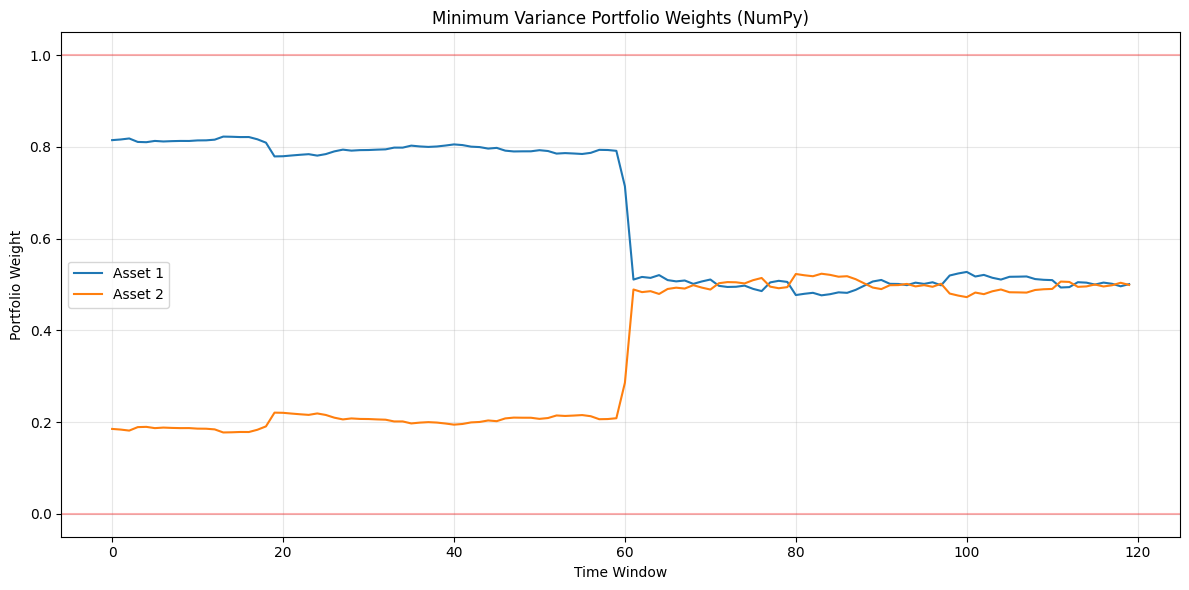

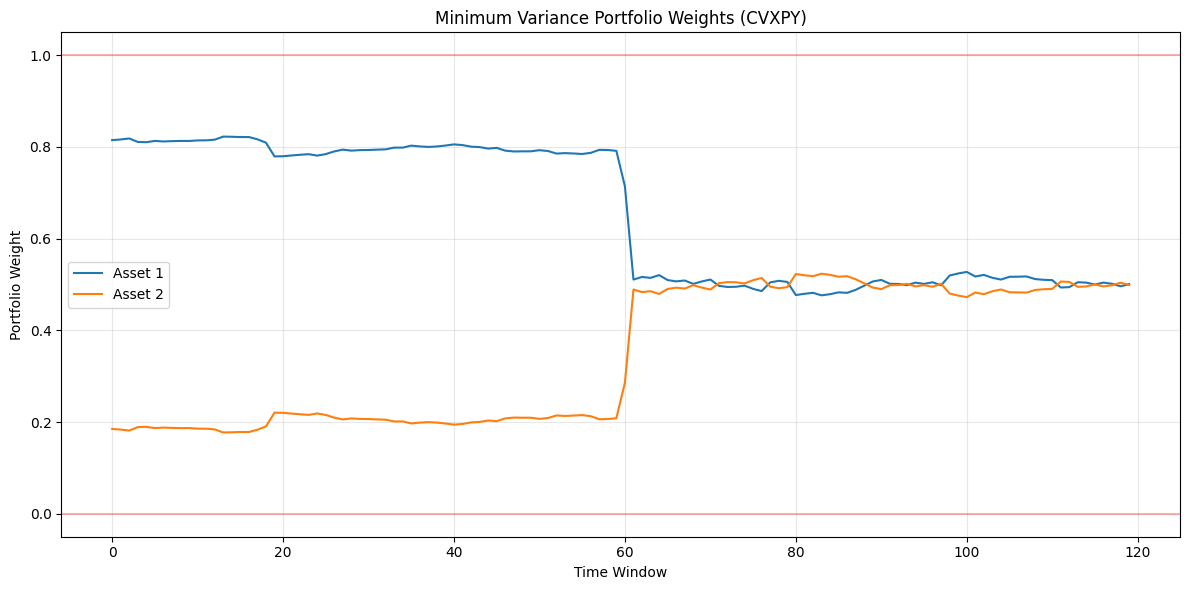

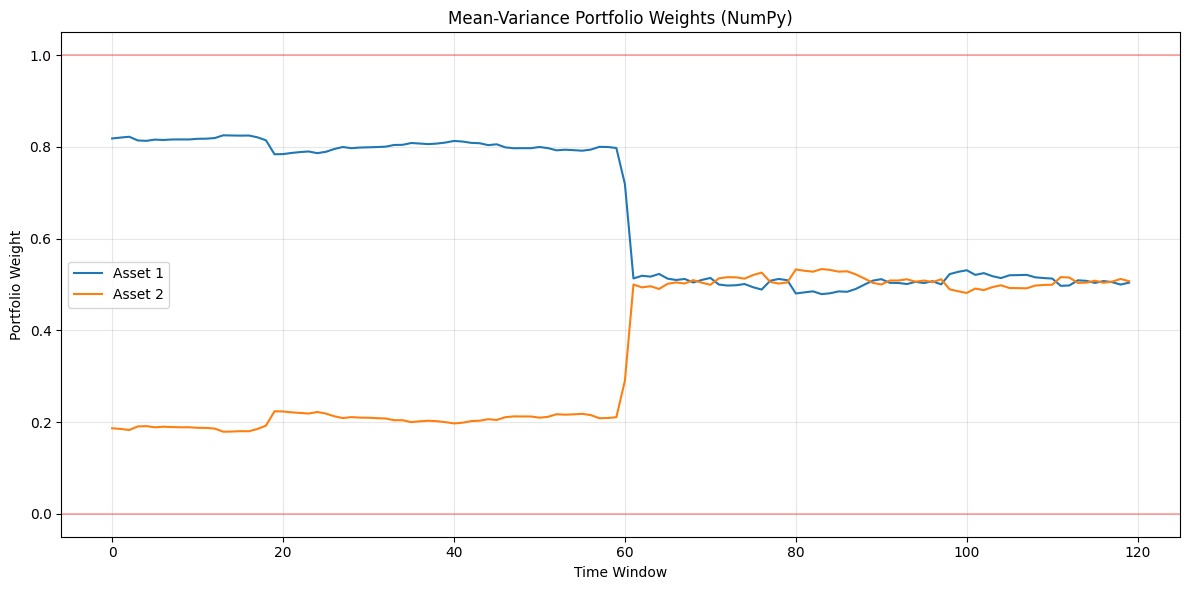

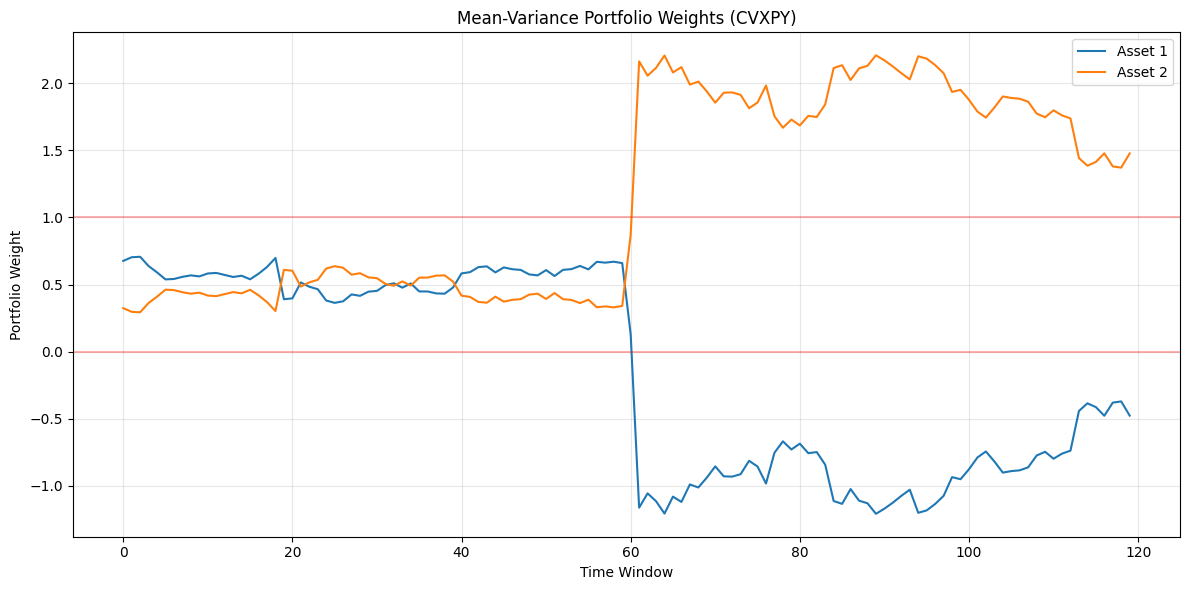

In [25]:
# NumPy 최소분산 포트폴리오 시뮬레이션
min_var_weights_np = rolling_horizon_simulation(returns, window_size, min_variance_portfolio_numpy)
plot_portfolio_weights(min_var_weights_np, 'Minimum Variance Portfolio Weights (NumPy)')

# CVXPY 최소분산 포트폴리오 시뮬레이션
min_var_weights_cvxpy = rolling_horizon_simulation(returns, window_size, min_variance_portfolio_cvxpy)
plot_portfolio_weights(min_var_weights_cvxpy, 'Minimum Variance Portfolio Weights (CVXPY)')

# NumPy 평균-분산 포트폴리오 시뮬레이션
mean_var_weights_np = rolling_horizon_simulation(returns, window_size, mean_variance_portfolio_numpy, gamma=1)
plot_portfolio_weights(mean_var_weights_np, 'Mean-Variance Portfolio Weights (NumPy)')

# CVXPY 평균-분산 포트폴리오 시뮬레이션
mean_var_weights_cvxpy = rolling_horizon_simulation(returns, window_size, mean_variance_portfolio_cvxpy, gamma=1)
plot_portfolio_weights(mean_var_weights_cvxpy, 'Mean-Variance Portfolio Weights (CVXPY)')

In [26]:
a

NameError: name 'a' is not defined

# M-portfolio

In [ ]:
def huber_loss(r, c=1.345):
    """Huber 손실 함수"""
    return np.where(np.abs(r) <= c, 0.5 * r**2, c * (np.abs(r) - 0.5 * c))

def m_portfolio_cvxpy(returns, c=1.345):
    """CVXPY를 사용한 M-추정량 기반 포트폴리오 계산"""
    n = returns.shape[1]  # 자산 수
    T = returns.shape[0]  # 샘플 수
    
    # 결정 변수 정의
    w = cp.Variable(n)  # 포트폴리오 가중치
    m = cp.Variable()   # 포트폴리오 수익의 M-추정량
    
    # 목적 함수 (Huber 손실 함수의 평균)
    # 참고: CVXPY에서는 huber 함수를 제공합니다
    obj_terms = [cp.huber(returns[t].T @ w - m, c) for t in range(T)]
    objective = cp.Minimize(sum(obj_terms) / T)
    
    # 제약 조건
    constraints = [cp.sum(w) == 1]
    
    # 문제 해결
    problem = cp.Problem(objective, constraints)
    problem.solve()
    
    return w.value

# S-portfolio